In [144]:
import h5py
import cv2
from sklearn.model_selection import train_test_split
import seaborn as sns



import os, sys, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2


ROOT_PATH = '..'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [145]:
def color(index, alpha=1):
    color_list = ['#0c6575', '#bbcbcb', '#23a98c', '#fc7a70', '#a07060',
                  '#003847', '#FFF7D6', '#5CA4B5', '#eeeeee']
    return f'{color_list[index % len(color_list)]}{int(255 * alpha):02x}'

In [146]:
df = pd.read_csv(f'{ROOT_PATH}/data/train.csv')
df.head(3)

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1


In [147]:
df_to_predict = pd.read_csv(f'{ROOT_PATH}/data/test.csv')
df_to_predict.head(3)

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638


Text(0.5, 1.0, 'Best index = 381')

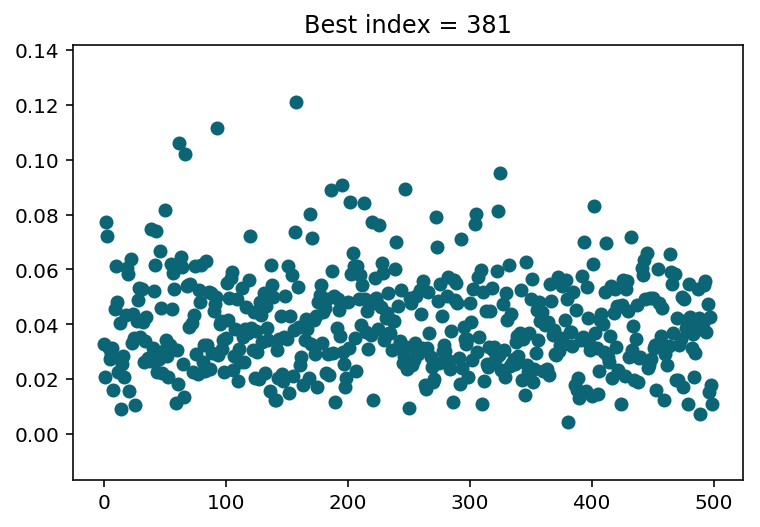

In [148]:
fair_scores = []
for random_state in range(500):
    df_train, df_dev_test = train_test_split(df, test_size=0.3, random_state=random_state, shuffle=True)
    df_train = df_train.reset_index(drop=True)
    df_dev_test = df_dev_test.reset_index(drop=True)
    fair_scores.append(np.std(df_dev_test['diagnosis'].value_counts()/df_train['diagnosis'].value_counts()))
    
plt.scatter(range(500), fair_scores, color=color(0))
best_index = np.argmin(fair_scores)
plt.title(f'Best index = {best_index}')

0    0.432540
2    0.425107
1    0.428571
4    0.425121
3    0.419118
Name: diagnosis, dtype: float64

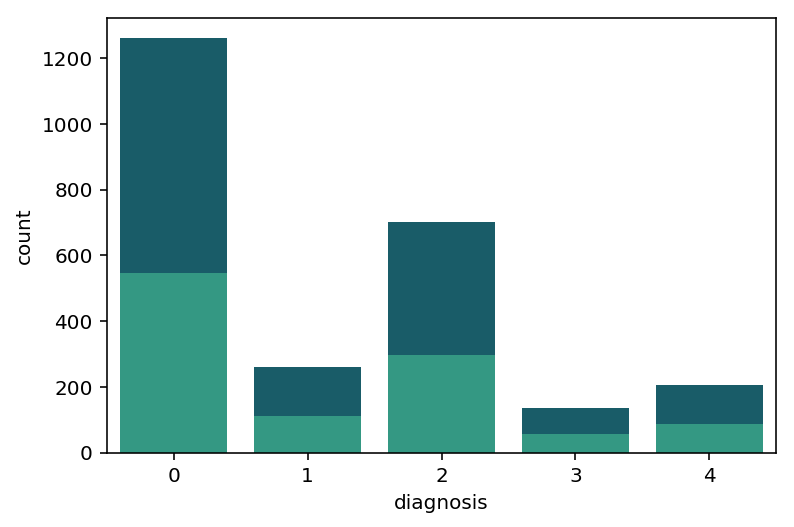

In [151]:
df_train, df_dev_test = train_test_split(df, test_size=0.3, random_state=best_index, shuffle=True)
df_train = df_train.reset_index(drop=True)
df_dev_test = df_dev_test.reset_index(drop=True)

ax = sns.countplot(df_train['diagnosis'], color=color(0))
sns.countplot(df_dev_test['diagnosis'], color=color(2), ax=ax)
df_dev_test['diagnosis'].value_counts()/df_train['diagnosis'].value_counts()

Text(0.5, 1.0, 'Best index = 76')

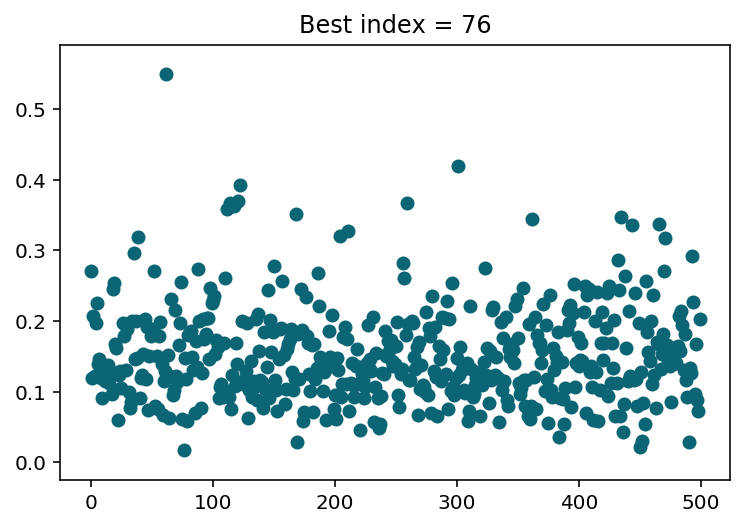

In [103]:
fair_scores = []
for random_state in range(500):
    df_dev, df_test = train_test_split(df_dev_test, test_size=0.5, random_state=random_state, shuffle=True)
    df_dev = df_dev.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    fair_scores.append(np.std(df_test['diagnosis'].value_counts()/df_dev['diagnosis'].value_counts()))
    
plt.scatter(range(500), fair_scores, color=color(0))
best_index_dev = np.argmin(fair_scores)
plt.title(f'Best index = {best_index_dev}')

0    1.003676
2    1.013514
1    0.982143
4    1.000000
3    0.965517
Name: diagnosis, dtype: float64

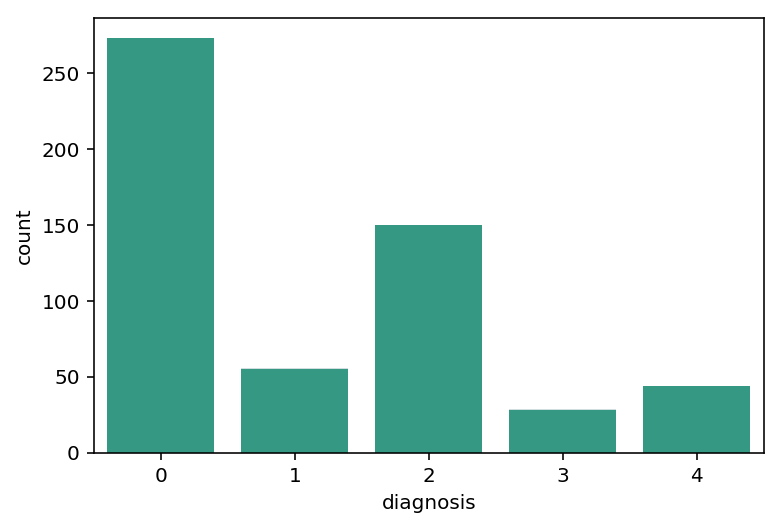

In [124]:
df_dev, df_test = train_test_split(df_dev_test, test_size=0.5, random_state=best_index_dev, shuffle=True)
df_dev = df_dev.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

ax = sns.countplot(df_dev['diagnosis'], color=color(0), alpha=0.2)
sns.countplot(df_test['diagnosis'], color=color(2), ax=ax)
df_test['diagnosis'].value_counts()/df_dev['diagnosis'].value_counts()

In [162]:
1/df_train['diagnosis'].value_counts()*1000

class_weight = {0:0.793651+5,
                2:1.426534+5,
                1:3.861004+5,
                4:4.830918+5,
                3:7.352941+5}

{0: -0.23111146096342045,
 2: 0.35524772594749116,
 1: 1.3509272532825987,
 4: 1.5750365117167675,
 3: 1.995100369246085}

# Saaving 299X299 (for Xception)

In [142]:
from keras.utils import np_utils

In [150]:
root_path = '..'
data_filename = f'{root_path}/data/data_xception.h5'
with h5py.File(data_filename, "w") as out:
    
    data_type = 'uint8'
    IMG_SIZE = 299
    NUM_CLASSES = 5
    
    out.create_dataset("X_train",(df_train.shape[0],IMG_SIZE,IMG_SIZE,3),dtype=data_type)
    out.create_dataset("y_train",(df_train.shape[0], NUM_CLASSES), dtype='int')
    
    out.create_dataset("X_dev",(df_dev.shape[0],IMG_SIZE,IMG_SIZE,3),dtype=data_type)
    out.create_dataset("y_dev",(df_dev.shape[0],NUM_CLASSES), dtype='int')
    
    out.create_dataset("X_test",(df_test.shape[0],IMG_SIZE,IMG_SIZE,3),dtype=data_type)
    out.create_dataset("y_test",(df_test.shape[0],NUM_CLASSES), dtype='int')
    
    out.create_dataset("X_to_predict", (df_to_predict.shape[0],IMG_SIZE,IMG_SIZE,3),dtype=data_type)

    for index, row in df_train.iterrows():
        img_path = f'{ROOT_PATH}/data/xception_train/{row.id_code}.png'
        out['X_train'][index, :, :, :] = cv2.imread(img_path)
        out['y_train'][index, :] = np_utils.to_categorical(row.diagnosis, num_classes=NUM_CLASSES).astype(np.int)
        
    for index, row in df_dev.iterrows():
        img_path = f'{ROOT_PATH}/data/xception_train/{row.id_code}.png'
        out['X_dev'][index, :, :, :] = cv2.imread(img_path)
        out['y_dev'][index, :] = np_utils.to_categorical(row.diagnosis, num_classes=NUM_CLASSES).astype(np.int)
        
    for index, row in df_test.iterrows():
        img_path = f'{ROOT_PATH}/data/xception_train/{row.id_code}.png'
        out['X_test'][index, :, :, :] = cv2.imread(img_path)
        out['y_test'][index, :] = np_utils.to_categorical(row.diagnosis, num_classes=NUM_CLASSES).astype(np.int)
        
    for index, row in df_to_predict.iterrows():
        img_path = f'{ROOT_PATH}/data/xception_test/{row.id_code}.png'
        out['X_to_predict'][index, :, :, :] = cv2.imread(img_path)

# Saving 512X512

In [10]:
# data_filename = f'{root_path}/data/data.h5'
# with h5py.File(data_filename, "w") as out:
    
#     data_type = 'uint8'
#     IMG_SIZE = 512
    
#     out.create_dataset("X_train",(df_train.shape[0],IMG_SIZE,IMG_SIZE,3),dtype=data_type)
#     out.create_dataset("y_train",(df_train.shape[0], 1),dtype='int')       
    
#     out.create_dataset("X_test",(df_test.shape[0],IMG_SIZE,IMG_SIZE,3),dtype=data_type)
#     out.create_dataset("y_test",(df_test.shape[0],1),dtype='int')
    
#     out.create_dataset("X_to_predict",(df_to_predict.shape[0],IMG_SIZE,IMG_SIZE,3),dtype=data_type)

#     for index, row in df_train.iterrows():
#         img_path = f'{ROOT_PATH}/data/train_processed/{row.id_code}.png'
#         out['X_train'][index, :, :, :] = cv2.imread(img_path)
#         out['y_train'][index, :] = row.diagnosis
        
#     for index, row in df_test.iterrows():
#         img_path = f'{ROOT_PATH}/data/train_processed/{row.id_code}.png'
#         out['X_test'][index, :, :, :] = cv2.imread(img_path)
#         out['y_test'][index, :] = row.diagnosis
        
#     for index, row in df_to_predict.iterrows():
#         img_path = f'{ROOT_PATH}/data/test_processed/{row.id_code}.png'
#         out['X_to_predict'][index, :, :, :] = cv2.imread(img_path)

## Test

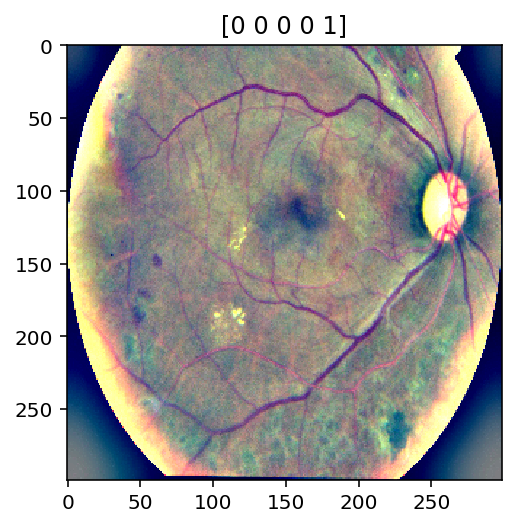

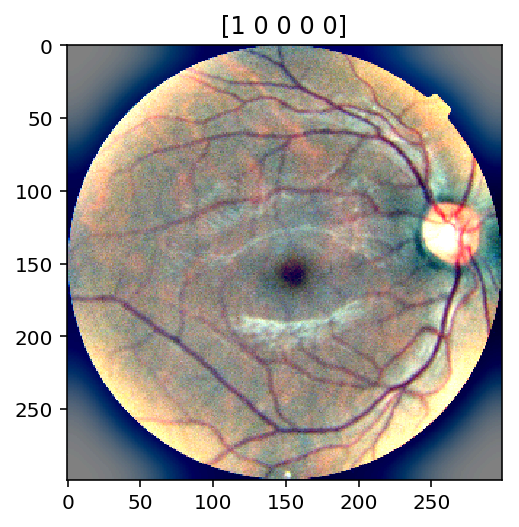

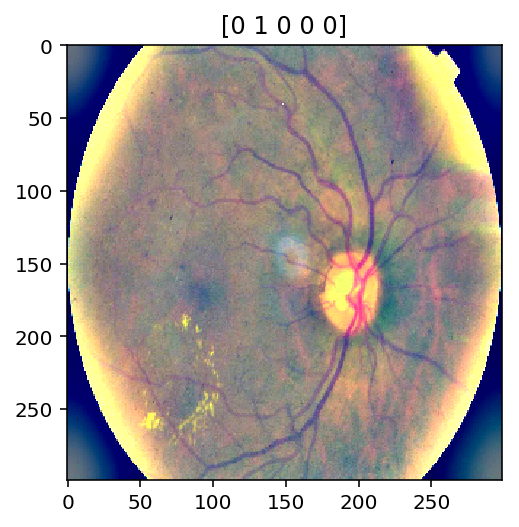

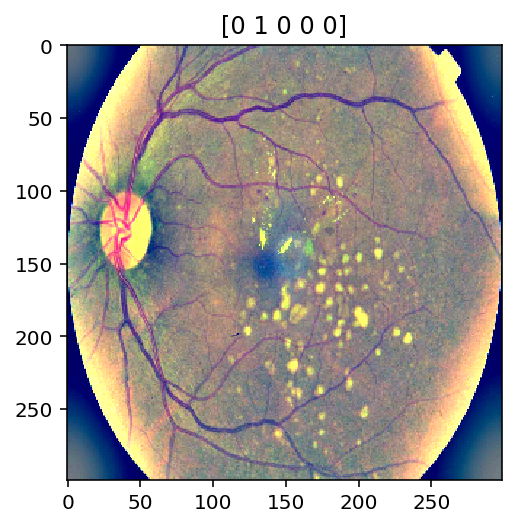

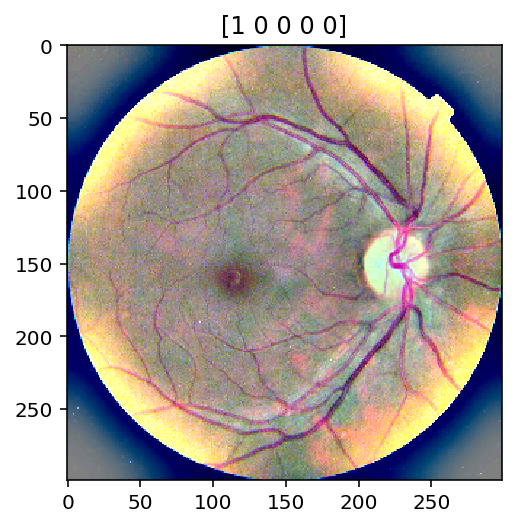

In [186]:

data_filename = f'{root_path}/data/data_xception.h5'


with h5py.File(data_filename, "r") as out:
    for i in range(5):
        sample_img = out['X_train'][i, :, :, :]
        diagnosis = out['y_train'][i, :]

        plt.title(str(diagnosis))
        plt.imshow(sample_img)
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


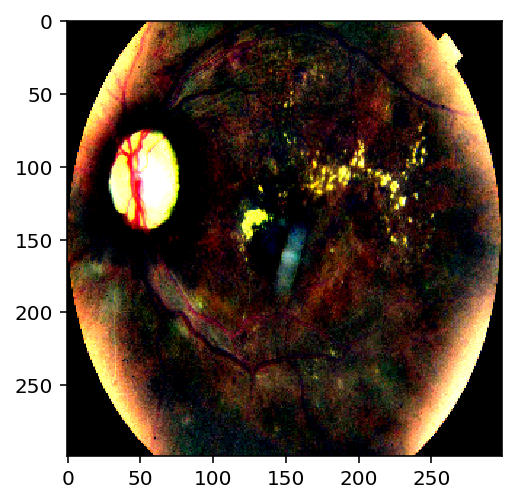

In [168]:
from keras.applications.xception import preprocess_input
preprocessed = preprocess_input(sample_img)
plt.imshow(preprocessed)

(array([ 13214.,   4189.,   8752.,  14002.,  49630., 114248.,  29534.,
         11966.,   6825.,  15843.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

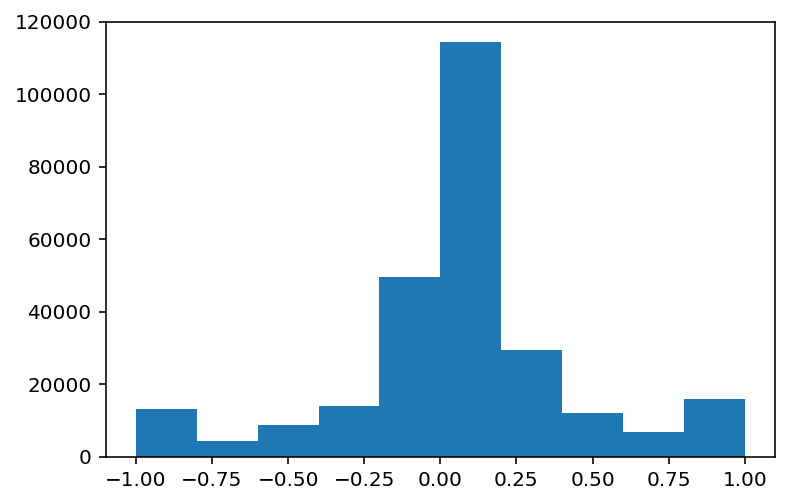

In [171]:
plt.hist(preprocessed.flatten())

(array([19968.,  3634.,  7515., 18167., 45918., 76119., 45379., 19174.,
        11004., 21325.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 10 Patch objects>)

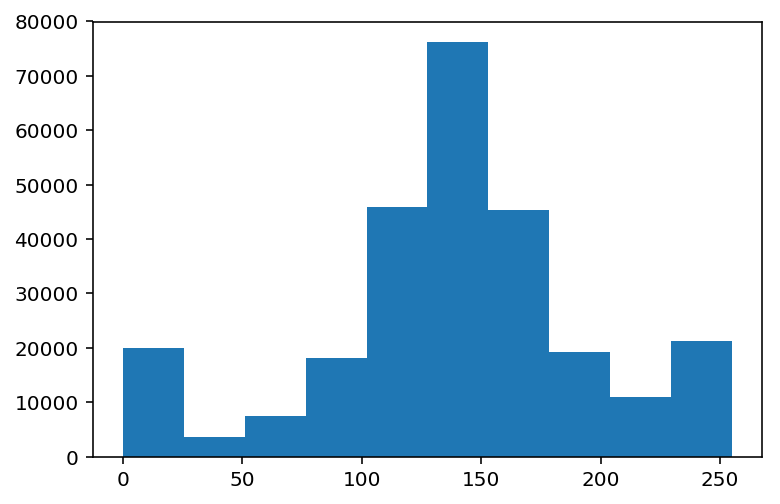

In [187]:
plt.hist(sample_img.flatten())